In [2]:
import emoji


config.json:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/789M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'path': '/home/ron/Documents/projects/startsaswisper/data/downloads/extracted/8d02b5743bcc41c4af0a6f9f9dc2027a29c5dc145612a675fdced025caef569c/dev_clean/1272/128104/1272-128104-0000.flac',
 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
        0.0010376 ]),
 'sampling_rate': 16000}

{'path': '/home/ron/Documents/projects/startsaswisper/data/downloads/extracted/8d02b5743bcc41c4af0a6f9f9dc2027a29c5dc145612a675fdced025caef569c/dev_clean/1272/128104/1272-128104-0000.flac',
 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
        0.0010376 ]),
 'sampling_rate': 16000}

In [138]:
sample= dataset[0]['audio']
processor.feature_(sample)

{'input_features': array([[[ 1.1933082e-01, -9.4576120e-02, -1.0977852e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [ 4.9346685e-04, -8.9271426e-02, -6.7289710e-02, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [-1.5326309e-01, -2.0803916e-01, -2.2226822e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        ...,
        [-8.0602670e-01, -8.0602670e-01, -7.9996610e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [-8.0602670e-01, -7.7211010e-01, -8.0602670e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [-8.0602670e-01, -8.0602670e-01, -8.0602670e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01]]], dtype=float32)}

In [40]:
processor= AutoProcessor.from_pretrained(model_id)
processor.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='distil-whisper/distil-medium.en', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|iw|>', '<|uk|>', '<|el

In [106]:
waveform

torch.Size([1, 77040])

In [125]:
waveform.shape

torch.Size([1, 77040])

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (3,2)

In [4]:
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    torch_dtype=torch_dtype,
    device=device,
)

In [193]:
import pytorch_lightning as pl
import jiwer
from typing import Union, Optional
from pathlib import Path
import datasets
import torchaudio


class WisperModel(pl.LightningModule):
    def __init__(self, model_id :str):
        # n_input = 1 for mono, 2 for stereo
        super().__init__()
        self.model = self.get_model(model_id)
   
    def get_model(self):
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
        model_id = model_id
        return AutoModelForSpeechSeq2Seq.from_pretrained( model_id, torch_dtype = torch_dtype, low_cpu_mem_usage=True, use_safetensors=True)

    def forward(self, x):
        return self.model(x)

    def predict_step(self, batch, batch_idx):
        inputs = processor( batch['array'], sampling_rate= batch['sampling_rate'], return_tensors = 'pt')
        logits = self(inputs['input_features'])
        result = processor.batch_decode(logits, skip_special_token= True)
        return result
    
    


class AudioDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, dataset_id, num_workers, batch_size=16):
        super().__init__()
        self.data_dir = data_dir
        self.dataset_id = dataset_id
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.dataset = datasets.load_dataset(self.dataset_id, "clean", split="validation", cache_dir=self.data_dir)


    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)




from pytorch_lightning import Trainer


data_loader = AudioDataModule(data_dir='data', dataset_id= "hf-internal-testing/librispeech_asr_dummy", num_workers=4)
model = WisperModel(model_id = "distil-whisper/distil-medium.en")
trainer = Trainer()
predictions = trainer.predict(model, data_loader)
    
                

UnboundLocalError: cannot access local variable 'model_id' where it is not associated with a value

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "distil-whisper/distil-medium.en"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

In [170]:
from datasets import load_dataset
import os
data_dir = os.path.join(os.getcwd(), "data")
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", cache_dir= data_dir)
sample = dataset[0]["audio"]

inputs = processor(sample['array'], sampling_rate=sample['sampling_rate'], return_tensors = 'pt')
with torch.no_grad():
    outputs = model.generate(inputs['input_features'])

result = processor.batch_decode(outputs, skip_special_token= True)


/home/ron/Documents/projects/startsaswisper/.venv/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


['<|startoftranscript|><|notimestamps|> Mr Quilter is the Apostle of the Middle Classes and we are glad to welcome his Gospel.<|endoftext|>']


In [167]:
outputs

tensor([[50257, 50362,  1770,  2264,   346,   353,   318,   262, 29748,   286,
           262,  6046, 38884,   290,   356,   389,  9675,   284,  7062,   465,
         23244,    13, 50256]])

In [146]:
features

{'input_features': array([[[ 1.1933082e-01, -9.4576120e-02, -1.0977852e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [ 4.9346685e-04, -8.9271426e-02, -6.7289710e-02, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [-1.5326309e-01, -2.0803916e-01, -2.2226822e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        ...,
        [-8.0602670e-01, -8.0602670e-01, -7.9996610e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [-8.0602670e-01, -7.7211010e-01, -8.0602670e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01],
        [-8.0602670e-01, -8.0602670e-01, -8.0602670e-01, ...,
         -8.0602670e-01, -8.0602670e-01, -8.0602670e-01]]], dtype=float32)}

In [99]:
sample

{'path': '/home/ron/Documents/projects/startsaswisper/data/downloads/extracted/8d02b5743bcc41c4af0a6f9f9dc2027a29c5dc145612a675fdced025caef569c/dev_clean/1272/128104/1272-128104-0000.flac',
 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
        0.0010376 ]),
 'sampling_rate': 16000}

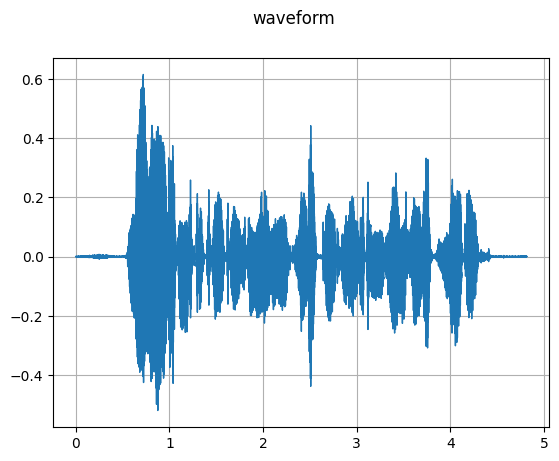

In [58]:
import torchaudio
import matplotlib.pyplot as plt

SAMPLE_WAV= 'data/downloads/extracted/8d02b5743bcc41c4af0a6f9f9dc2027a29c5dc145612a675fdced025caef569c/dev_clean/1272/128104/1272-128104-0001.flac'

waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

plot_waveform(waveform, sample_rate)



In [59]:
waveform

tensor([[-1.5259e-04, -9.1553e-05, -1.8311e-04,  ...,  9.7656e-04,
          9.4604e-04, -4.8828e-04]])

In [20]:
sample

{'path': '/home/ron/.cache/huggingface/datasets/downloads/extracted/b1fa37539b73e57c95d31735153bade89bd851038d777c3fb1bb96c89555b374/dev_clean/1272/128104/1272-128104-0000.flac',
 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
        0.0010376 ]),
 'sampling_rate': 16000}

In [26]:
result = pipe(sample)
print(result["text"])

 Mr Quilter is the Apostle of the Middle Classes and we are glad to welcome his Gospel.


In [30]:
result['text'].lower()

' mr quilter is the apostle of the middle classes and we are glad to welcome his gospel.'